# Demonstrate the FFT

Here we demonstrate how the FFT works on two cases:

1. A single-frequency sine wave
1. The [input CO$_2$ data from Mauna Loa Observatory](https://www.esrl.noaa.gov/gmd/ccgg/trends/)

In each case, we will look at the waveform in the "time" domain (which can also be the spatial domain depending on your dataset). We will take the FFT to transform to the "frequency" domain. However, *be extremely careful* with the FFT because the $x$-axis is *NOT* the frequency, but the spectral index. Given $N$ samples in the FFT, the true frequency $f$ is related to the spectral index $k$ by


$f = k/N$

In this case, $N = 1024$ and $k = 10$, so if the $x$ axis in the time domain is assumed to be in seconds, the frequency is $f=0.0098$ Hz. 



In [1]:
import matplotlib.pyplot as plt

from fft import fft as fft
import numpy as np
import math

In [2]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

## Simple Sine Wave

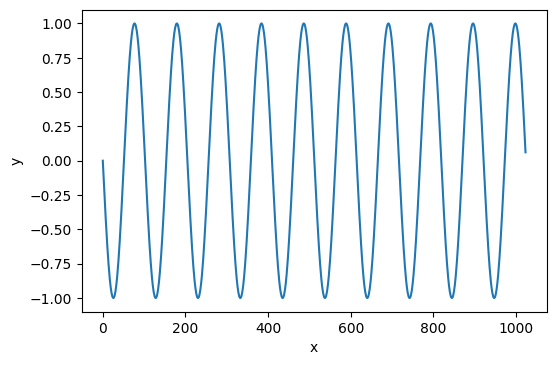

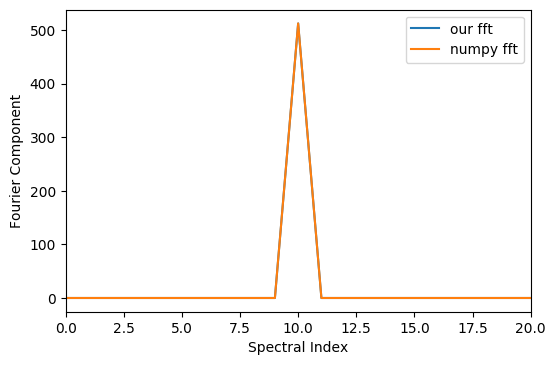

In [3]:
N = 1024 # number of samples
k = 10.0 # frequency / N
x = np.arange(N) 
y = np.sin( -2. * np.pi * k /N * x ) 
Y = fft(y)  # Our FFT implementation
Ynp = np.fft.fft(y) # Numpy's FFT implementation
Y_abs = abs(Y)
Ynp_abs = abs(Y)

f1 = plt.figure(1)
plt.plot( x, y )
plt.xlabel('x')
plt.ylabel('y')

f2 = plt.figure(2)
plt.plot( x, Y_abs, label="our fft" )
plt.plot( x, Ynp_abs, label="numpy fft")
plt.ylabel('Fourier Component')
plt.xlabel('Spectral Index')
plt.legend()
plt.xlim([0,20])

plt.show()

## CO$_2$ Data

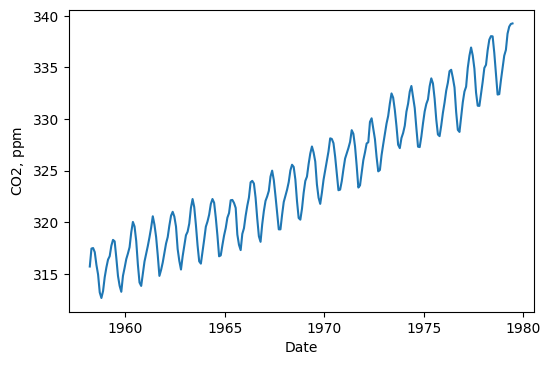

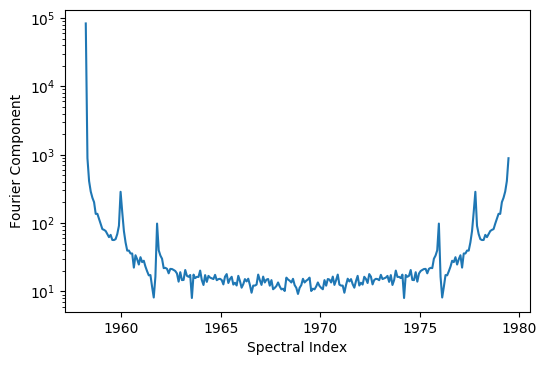

In [4]:
from read_co2 import read_co2

x,y = read_co2('co2_mm_mlo.txt')

y_valid = y >= 0.
y = y[y_valid]
x = x[y_valid]

y =y[0:256]
x =x[0:256]
Y = fft(y)

Y_abs = abs(Y)


f1 = plt.figure(1)
plt.plot( x, y )
plt.ylabel('CO${2}$, ppm')
plt.xlabel('Date')

f2 = plt.figure(2)
plt.plot( x, Y_abs )
plt.yscale('log')
plt.ylabel('Fourier Component')

plt.xlabel('Spectral Index')

plt.show()

